# XGBoost (Dataset in_vivo)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem, RDLogger
from rdkit.Chem import Descriptors
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.ML.Descriptors import MoleculeDescriptors as md
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    RepeatedStratifiedKFold,
    cross_val_score,
    cross_validate,
    RandomizedSearchCV
)
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    classification_report,
    confusion_matrix
)
import xgboost as xgb
from xgboost import XGBClassifier
import shap
import optuna
from rdkit import DataStructs

## Molecule, Descriptor and Outlier Functions

In [3]:
def molecule_from_smiles(smiles):
    lg = RDLogger.logger()
    # Temporarily silence RDKit logs (Only critical)
    lg.setLevel(RDLogger.CRITICAL)
    try:
        # Extract molecule
        molecule = Chem.MolFromSmiles(smiles, sanitize=True)
        if molecule is None:
            return None, "failed"

        # Remove salts
        clean_molecule = rdMolStandardize.LargestFragmentChooser()
        molecule = clean_molecule.choose(molecule)

        # Sanitize molecule again to reflect changes
        Chem.SanitizeMol(molecule)
        return molecule, "succeed"
    except Exception as e:
        return None, f"error: {e}"
    finally:
        # re-enable logging afterward
        lg.setLevel(RDLogger.INFO)


def calculate_descriptors(molecule):
    # Get all descriptors (1D/2D)
    descriptor_names = []
    for descriptor, _ in Descriptors._descList:
        descriptor_names.append(descriptor)

    # Use descriptors to calculate values
    calculator = md.MolecularDescriptorCalculator(descriptor_names)
    descriptor_values = calculator.CalcDescriptors(molecule)

    # Create dictionary
    descriptors = dict(zip(descriptor_names, descriptor_values))
    return descriptors


def compute_iqr_limits(df, factor=1.5):
    # Calculate IQR limits
    limits = {}
    for col in df.columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1

        # If IQR is 0 - column is too flat - skip
        if iqr == 0 or np.isnan(iqr):
            continue

        lower = q1 - factor * iqr
        upper = q3 + factor * iqr
        limits[col] = (lower, upper)
    return limits


def apply_iqr_limits(df, limits):
    # Apply the limits
    df_clipped = df.copy()
    for col, (lower, upper) in limits.items():
        df_clipped[col] = df_clipped[col].clip(lower, upper)
    return df_clipped


def smiles_to_rdkit_fp(smiles, n_bits=256):
    # Molecule from SMILES
    mol, state = molecule_from_smiles(smiles)

    # If molecule is none
    if mol is None:
        return np.zeros(n_bits, dtype=int)

    # Compute RDKit fingerprint
    fp = Chem.RDKFingerprint(mol, fpSize=n_bits)
    arr = np.zeros((n_bits,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr


## Dataset Processing

In [4]:
# Configuration
ORIG_DATASET = "datasets/in_vivo_dataset_homolumo_processed.xlsx"
SKIP_ROWS = 0
SMILES_COL = "SMILES code"
TARGET_COL = "Phototoxicity"
HOMO_COL = "HOMO_eV"
LUMO_COL = "LUMO_eV"
HL_GAP_COL = "HL_Gap_eV"
FULL_OUTPUT_DATASET = "in_vivo_dataset_processed.xlsx"

# Outputs
TRAIN_X_CSV = "in_chemico_x_train.csv"
TEST_X_CSV = "in_chemico_x_test.csv"
TRAIN_Y_CSV = "in_chemico_y_train.csv"
TEST_Y_CSV = "in_chemico_y_test.csv"

# Near constant threshold - tolerance
SIMILARITY_THRESHOLD = 0.90
# Correlation threshold
CORRELATION_THRESHOLD = 0.95

# Load dataset and skip first row (Header)
dataset = pd.read_excel(ORIG_DATASET, engine="openpyxl", skiprows=SKIP_ROWS)

# Build descriptors
descriptor_rows = []
state_molecules = []
molecules = []

# Loop over the SMILES column
for smiles in dataset[SMILES_COL].astype(str):
    molecule, state = molecule_from_smiles(smiles)
    state_molecules.append(state)
    molecules.append(molecule)

    # If molecule construction failed - empty placeholder
    if molecule is None:
        descriptor_rows.append({})
        continue
    # Calculate descriptors for each molecule
    descriptor_rows.append(calculate_descriptors(molecule))

# Convert list of dictionaries into dataframe
descriptor_data_all = pd.DataFrame(descriptor_rows)

# Add HOMO/LUMO/HL_Gap columns
extra_cols = [HOMO_COL, LUMO_COL, HL_GAP_COL]

descriptor_data_all[extra_cols] = dataset[extra_cols].reset_index(drop=True)

# Keep everything + status
output = pd.concat(
    [dataset.reset_index(drop=True), descriptor_data_all.reset_index(drop=True)],
    axis=1
)
output["MoleculeStatus"] = state_molecules

# Output whole dataset with descriptors and state
with pd.ExcelWriter(FULL_OUTPUT_DATASET, engine="openpyxl") as writer:
    output.to_excel(writer, index=False, sheet_name="Descriptors")

print(f"Full - Rows: {len(output)}/Columns: {output.shape[1]}")
print(output.head().to_string(index=False))

# Drop failed molecules - boolean array
molecules_right = []
for molecule in molecules:
    if molecule is not None:
        molecules_right.append(True)
    else:
        molecules_right.append(False)
if not any(molecules_right):
    raise ValueError("No valid molecules after SMILES parsing.")

dataset_ok = dataset.loc[molecules_right].reset_index(drop=True)
descriptor_ok = descriptor_data_all.loc[molecules_right].reset_index(drop=True)

# Target
y_full = dataset_ok[TARGET_COL].astype(int)

# Take only numeric descriptor columns
X_full = descriptor_ok.select_dtypes(include=[np.number]).copy()
for column in X_full.columns:
    X_full[column] = X_full[column].replace([np.inf, -np.inf], np.nan)

# Drop columns that are entirely NaN
all_nan_cols = X_full.columns[X_full.isna().all()].tolist()
if all_nan_cols:
    print(f"Dropping {len(all_nan_cols)} NaN columns.")
    X_full = X_full.drop(columns=all_nan_cols)

# Split dataset - train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

# Calculate medians for each column in train only
train_medians = X_train.median(numeric_only=True)

# Fill missing values in both train and test using those medians
X_train = X_train.fillna(train_medians)
X_test = X_test.fillna(train_medians)

# Compute constants on train only
constant_cols = []
for col in X_train.columns:
    top_freq = X_train[col].value_counts(normalize=True, dropna=False).max()
    if top_freq >= SIMILARITY_THRESHOLD:
        constant_cols.append(col)

# Drop from train and apply same drop to test
if constant_cols:
    X_train = X_train.drop(columns=constant_cols)
    X_test = X_test.drop(columns=constant_cols)
    print(f"Dropped {len(constant_cols)} constant/almost-constant columns.")

# Compute absolute correlation matrix on training data
corr_matrix = X_train.corr().abs()
# Keep only upper triangle of the matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Find columns to drop - correlation
high_corr_cols = []
for col in upper.columns:
    if any(upper[col] > CORRELATION_THRESHOLD):
        high_corr_cols.append(col)

# Drop from both train and test
if high_corr_cols:
    X_train = X_train.drop(columns=high_corr_cols)
    X_test = X_test.drop(columns=high_corr_cols)
    print(f"Dropped {len(high_corr_cols)} highly correlated columns.")

# Compute IQR limits on training data
iqr_limits = compute_iqr_limits(X_train, factor=1.5)

# Apply limits to both train and test sets
X_train = apply_iqr_limits(X_train, iqr_limits)
X_test = apply_iqr_limits(X_test, iqr_limits)

X_train = pd.DataFrame(X_train, columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(X_test, columns=X_test.columns, index=X_test.index)

X_train.to_csv(TRAIN_X_CSV, index=False)
X_test.to_csv(TEST_X_CSV, index=False)
y_train.to_csv(TRAIN_Y_CSV, index=False, header=[TARGET_COL])
y_test.to_csv(TEST_Y_CSV, index=False, header=[TARGET_COL])

print(f"Train - Rows: {len(X_train)}/Columns: {X_train.shape[1]}")
print("First rows of train x:")
print(X_train.head().to_string(index=False))
print(f"Test - Rows: {len(X_test)}/Columns: {X_test.shape[1]}")
print("First rows of train y:")
print(y_train.head().to_string(index=False))
X_train.describe()

print("\nTrain set class counts:")
print(y_train.value_counts())
print("\nTrain set class ratio:")
print(y_train.value_counts(normalize=True))

print("\nTest set class counts:")
print(y_test.value_counts())
print("\nTest set class ratio:")
print(y_test.value_counts(normalize=True))

# Calculate fingerprint - added after all of processing
n_bits = 256
smiles_series = dataset_ok[SMILES_COL].astype(str)

fp_list = [smiles_to_rdkit_fp(s, n_bits=n_bits) for s in smiles_series]
fp_array = np.vstack(fp_list)

fp_cols = [f"RDKit_fp_{i}" for i in range(n_bits)]
fps_full = pd.DataFrame(fp_array, columns=fp_cols, index=dataset_ok.index)

# Align fingerprints with train/test indices
fp_train = fps_full.loc[X_train.index]
fp_test = fps_full.loc[X_test.index]

Full - Rows: 35/Columns: 232
                       Name                                                                                                                                         IUPAC name CAS registry number      Structure  Phototoxicity                                                                             SMILES code                                          Sources  Note  HOMO_eV  LUMO_eV  HL_Gap_eV MoleculeStatus  MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex      qed       SPS   MolWt  HeavyAtomMolWt  ExactMolWt  NumValenceElectrons  NumRadicalElectrons  MaxPartialCharge  MinPartialCharge  MaxAbsPartialCharge  MinAbsPartialCharge  FpDensityMorgan1  FpDensityMorgan2  FpDensityMorgan3  BCUT2D_MWHI  BCUT2D_MWLOW  BCUT2D_CHGHI  BCUT2D_CHGLO  BCUT2D_LOGPHI  BCUT2D_LOGPLOW  BCUT2D_MRHI  BCUT2D_MRLOW   AvgIpc  BalabanJ     BertzCT      Chi0     Chi0n     Chi0v      Chi1     Chi1n     Chi1v     Chi2n     Chi2v    Chi3n    Chi3v    Chi4n    Chi4v 

## Base Model Train

In [5]:
base_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric=["logloss", "auc"],
    random_state=42
)
# Train
base_model.fit(X_train, y_train)

# Predict
y_pred = base_model.predict(X_test)
y_prob = base_model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nModel performance:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))


Model performance:
Accuracy:  0.4286
Precision: 0.5000
Recall:    0.5000
F1 score:  0.5000
ROC AUC:   0.3333

Classification report:
              precision    recall  f1-score   support

           0      0.333     0.333     0.333         3
           1      0.500     0.500     0.500         4

    accuracy                          0.429         7
   macro avg      0.417     0.417     0.417         7
weighted avg      0.429     0.429     0.429         7



## Feature Selection

/tmp/ipykernel_61192/335949761.py:38: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train)


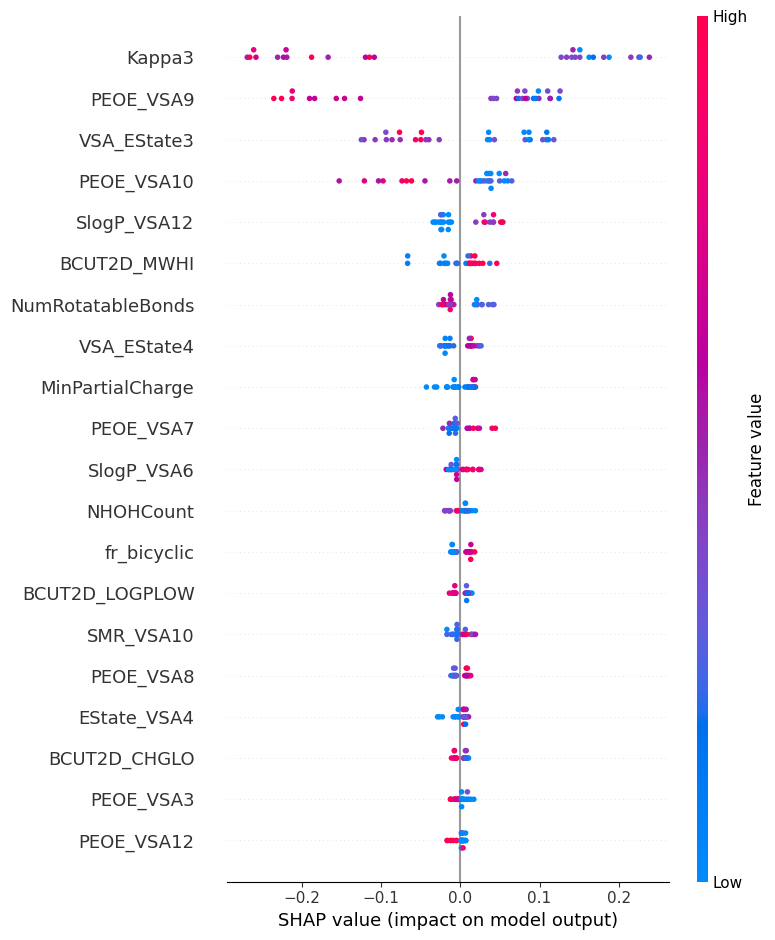

In [6]:
# SHAP features
# Prediction function for SHAP
f = lambda X: base_model.predict_proba(X)[:, 1]

explainer = shap.Explainer(f, X_train)
shap_result = explainer(X_train)

# Each row has values for features
shap_values = shap_result.values

# Mean absolute SHAP value per feature (importance)
shap_importance = np.abs(shap_values).mean(axis=0)
shap_features = pd.Series(shap_importance, index=X_train.columns).sort_values(ascending=False)

# XGBoost features
xgb_importance = pd.Series(base_model.feature_importances_, index=X_train.columns)
xgb_features = xgb_importance.sort_values(ascending=False)

# K-Best - Anova features
kbest = SelectKBest(score_func=f_classif, k='all')
kbest.fit(X_train, y_train)
kbest_scores = pd.Series(kbest.scores_, index=X_train.columns).fillna(0.0)
kbest_features = kbest_scores.sort_values(ascending=False)

# Lasso features
lasso = LogisticRegression(
    penalty='l1',
    C=1.0,
    solver='liblinear',
    max_iter=5000
)
lasso.fit(X_train, y_train)

lasso_importance = pd.Series(np.abs(lasso.coef_).ravel(), index=X_train.columns)
lasso_features = lasso_importance.sort_values(ascending=False)

# Plot
shap.summary_plot(shap_values, X_train)

In [7]:
shap_features.head(30)

Kappa3                             0.187243
PEOE_VSA9                          0.118998
VSA_EState3                        0.077553
PEOE_VSA10                         0.052098
SlogP_VSA12                        0.029051
BCUT2D_MWHI                        0.021140
NumRotatableBonds                  0.019796
VSA_EState4                        0.017097
MinPartialCharge                   0.014554
PEOE_VSA7                          0.013081
SlogP_VSA6                         0.010391
NHOHCount                          0.009824
fr_bicyclic                        0.009531
BCUT2D_LOGPLOW                     0.008775
SMR_VSA10                          0.008391
PEOE_VSA8                          0.008240
EState_VSA4                        0.007680
BCUT2D_CHGLO                       0.006855
PEOE_VSA3                          0.006168
PEOE_VSA12                         0.005193
qed                                0.004652
SlogP_VSA3                         0.000042
LUMO_eV                         

In [8]:
xgb_features.head(30)

PEOE_VSA7                  0.132607
Kappa3                     0.111020
PEOE_VSA9                  0.092091
PEOE_VSA10                 0.084834
SlogP_VSA6                 0.080360
VSA_EState3                0.071299
NHOHCount                  0.054085
BCUT2D_MWHI                0.048857
MinPartialCharge           0.042497
SMR_VSA10                  0.042226
EState_VSA4                0.041698
NumRotatableBonds          0.028208
PEOE_VSA12                 0.026741
fr_bicyclic                0.025766
PEOE_VSA3                  0.023361
SlogP_VSA12                0.023123
BCUT2D_LOGPLOW             0.019320
VSA_EState4                0.017926
PEOE_VSA8                  0.016693
BCUT2D_CHGLO               0.011904
qed                        0.005385
NumSaturatedCarbocycles    0.000000
NumHeterocycles            0.000000
NumHeteroatoms             0.000000
NumHAcceptors              0.000000
NumAtomStereoCenters       0.000000
NumAromaticRings           0.000000
NumAmideBonds              0

In [9]:
kbest_features.head(30)

PEOE_VSA9              14.363126
Kappa3                  6.864427
MinAbsEStateIndex       6.556797
fr_NH1                  6.493320
MinEStateIndex          5.996807
NumRotatableBonds       5.906943
NumHeteroatoms          5.806819
fr_Ar_OH                5.802317
SMR_VSA1                5.730514
SlogP_VSA11             5.346121
Kappa2                  4.789552
NOCount                 4.568648
PEOE_VSA2               4.470182
SlogP_VSA3              4.449977
NHOHCount               4.208092
fr_methoxy              3.628406
EState_VSA8             3.598152
NumValenceElectrons     3.472717
EState_VSA10            3.465777
EState_VSA3             3.326305
VSA_EState1             3.266035
MaxAbsEStateIndex       3.158398
SlogP_VSA4              3.158356
MaxPartialCharge        2.802221
Ipc                     2.736197
MolWt                   2.648553
LUMO_eV                 2.611189
EState_VSA2             2.547447
SMR_VSA9                2.481089
NumHAcceptors           2.433878
dtype: flo

In [10]:
lasso_features.head(30)

SlogP_VSA3                  4.669605e-01
PEOE_VSA9                   3.562066e-01
PEOE_VSA11                  2.406096e-01
EState_VSA7                 2.208773e-01
EState_VSA2                 2.050352e-01
EState_VSA4                 2.035043e-01
BCUT2D_MWHI                 1.885655e-01
EState_VSA3                 1.340987e-01
VSA_EState2                 1.039794e-01
EState_VSA5                 9.333788e-02
EState_VSA6                 8.787377e-02
PEOE_VSA7                   5.995505e-02
SlogP_VSA2                  3.183351e-02
EState_VSA1                 2.685619e-02
PEOE_VSA6                   1.252066e-02
BertzCT                     5.326258e-03
MolWt                       1.072064e-04
Ipc                         2.741538e-07
NumAromaticHeterocycles     0.000000e+00
NumAromaticCarbocycles      0.000000e+00
NumAromaticRings            0.000000e+00
NumAtomStereoCenters        0.000000e+00
NumAliphaticCarbocycles     0.000000e+00
NumHAcceptors               0.000000e+00
NumAmideBonds   

## Model SHAP Features Tuning (Randomized Search CV)


=== Testing top 5 features ===


Best parameters: {'subsample': 0.6, 'n_estimators': 80, 'max_depth': 5, 'learning_rate': 0.3, 'colsample_bytree': 0.6}
Accuracy: 0.429 | ROC-AUC: 0.167

=== Testing top 6 features ===
Best parameters: {'subsample': 0.7, 'n_estimators': 70, 'max_depth': 6, 'learning_rate': 0.2, 'colsample_bytree': 0.8}
Accuracy: 0.429 | ROC-AUC: 0.250

=== Testing top 7 features ===
Best parameters: {'subsample': 0.7, 'n_estimators': 40, 'max_depth': 7, 'learning_rate': 0.2, 'colsample_bytree': 0.7}
Accuracy: 0.429 | ROC-AUC: 0.333

=== Testing top 8 features ===
Best parameters: {'subsample': 0.7, 'n_estimators': 70, 'max_depth': 6, 'learning_rate': 0.2, 'colsample_bytree': 0.8}
Accuracy: 0.429 | ROC-AUC: 0.333

=== Testing top 9 features ===
Best parameters: {'subsample': 0.7, 'n_estimators': 50, 'max_depth': 4, 'learning_rate': 0.3, 'colsample_bytree': 0.7}
Accuracy: 0.286 | ROC-AUC: 0.250

=== Testing top 10 features ===
Best parameters: {'subsample': 0.6, 'n_estimators': 50, 'max_depth': 4, 'learni

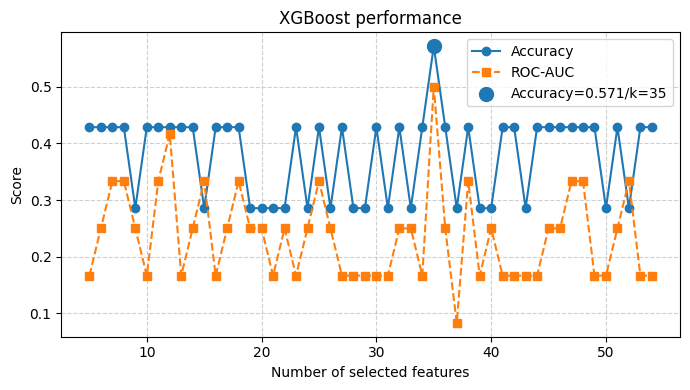


Accuracy = 0.571/ROC-AUC = 0.500/k = 35


In [11]:
ranking = shap_features

param_dist = {
    "n_estimators": np.arange(20, 90, 10),
    "max_depth": [3, 4, 5, 6, 7],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
}

results = []
for k in range(5, 55, 1):
    print(f"\n=== Testing top {k} features ===")

    # Select k values
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    )

    search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_dist,
        n_iter=200,
        scoring="accuracy",
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Analyze
results = np.array(results)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

# Choose best by accuracy
best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, 'o-', label='Accuracy')
plt.plot(feature_counts, auc_scores, 's--', label='ROC-AUC')
plt.scatter(best_k, best_acc, s=100, zorder=5, label=f'Accuracy={best_acc:.3f}/k={best_k}')
plt.title('XGBoost performance')
plt.xlabel('Number of selected features')
plt.ylabel('Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nAccuracy = {best_acc:.3f}/ROC-AUC = {best_auc:.3f}/k = {best_k}")

## Model SHAP Features Tuning (Randomized Search CV) - Fingerprint

In [12]:
# Select the best_k features
top_feats_best = ranking.head(best_k).index.tolist()
print(f"\nUsing best_k = {best_k} features: {len(top_feats_best)} selected.")

X_train_sel = X_train[top_feats_best].copy()
X_test_sel = X_test[top_feats_best].copy()

# Concatenate best_k descriptors + fingerprints
X_train_final = pd.concat([X_train_sel, fp_train], axis=1)
X_test_final = pd.concat([X_test_sel, fp_test], axis=1)

print(f"Final train shape with fingerprints: {X_train_final.shape}")
print(f"Final test shape with fingerprints:  {X_test_final.shape}")

# RandomizedSearchCV
xgb_clf_final = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    random_state=42,
    n_jobs=-1
)

search_final = RandomizedSearchCV(
    estimator=xgb_clf_final,
    param_distributions=param_dist,
    n_iter=200,
    scoring="accuracy",
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

search_final.fit(X_train_final, y_train)

best_model_final = search_final.best_estimator_
y_pred_final = best_model_final.predict(X_test_final)
y_prob_final = best_model_final.predict_proba(X_test_final)[:, 1]

acc_final = accuracy_score(y_test, y_pred_final)
auc_final = roc_auc_score(y_test, y_prob_final)

print("\n=== FINAL MODEL (best_k + 256-bit RDKit fingerprint) ===")
print(f"Best parameters: {search_final.best_params_}")
print(f"Test Accuracy: {acc_final:.3f}")
print(f"Test ROC-AUC: {auc_final:.3f}")


Using best_k = 35 features: 35 selected.
Final train shape with fingerprints: (28, 291)
Final test shape with fingerprints:  (7, 291)

=== FINAL MODEL (best_k + 256-bit RDKit fingerprint) ===
Best parameters: {'subsample': 0.7, 'n_estimators': 40, 'max_depth': 7, 'learning_rate': 0.2, 'colsample_bytree': 0.7}
Test Accuracy: 0.286
Test ROC-AUC: 0.167


## Model XGB Features Tuning (Randomized Search CV)


=== Testing top 5 features ===
Best parameters: {'subsample': 0.9, 'n_estimators': 30, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.7}
Accuracy: 0.429 | ROC-AUC: 0.167

=== Testing top 6 features ===
Best parameters: {'subsample': 1.0, 'n_estimators': 20, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.6}
Accuracy: 0.286 | ROC-AUC: 0.167

=== Testing top 7 features ===
Best parameters: {'subsample': 0.9, 'n_estimators': 60, 'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.9}
Accuracy: 0.286 | ROC-AUC: 0.083

=== Testing top 8 features ===
Best parameters: {'subsample': 0.6, 'n_estimators': 30, 'max_depth': 6, 'learning_rate': 0.05, 'colsample_bytree': 0.9}
Accuracy: 0.286 | ROC-AUC: 0.167

=== Testing top 9 features ===
Best parameters: {'subsample': 0.9, 'n_estimators': 20, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.6}
Accuracy: 0.429 | ROC-AUC: 0.333

=== Testing top 10 features ===
Best parameters: {'subsample': 1.0, 'n_est

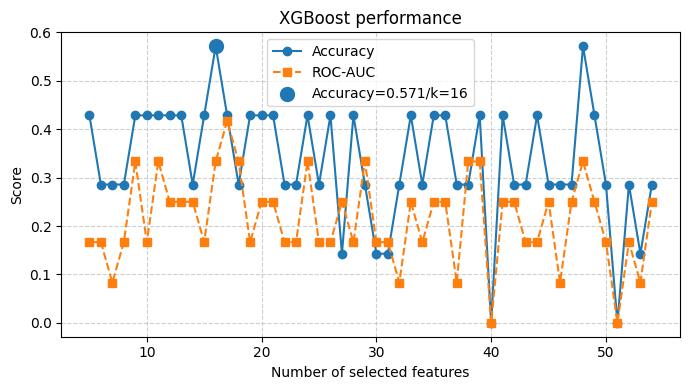


Accuracy = 0.571/ROC-AUC = 0.333/k = 16


In [13]:
ranking = xgb_features

param_dist = {
    "n_estimators": np.arange(20, 90, 10),
    "max_depth": [3, 4, 5, 6, 7],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
}

results = []
for k in range(5, 55, 1):
    print(f"\n=== Testing top {k} features ===")

    # Select k values
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    )

    search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_dist,
        n_iter=200,
        scoring="accuracy",
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Analyze
results = np.array(results)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

# Choose best by accuracy
best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, 'o-', label='Accuracy')
plt.plot(feature_counts, auc_scores, 's--', label='ROC-AUC')
plt.scatter(best_k, best_acc, s=100, zorder=5, label=f'Accuracy={best_acc:.3f}/k={best_k}')
plt.title('XGBoost performance')
plt.xlabel('Number of selected features')
plt.ylabel('Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nAccuracy = {best_acc:.3f}/ROC-AUC = {best_auc:.3f}/k = {best_k}")

## Model XGB Features Tuning (Randomized Search CV) - Fingerprint

In [14]:
# Select the best_k features
top_feats_best = ranking.head(best_k).index.tolist()
print(f"\nUsing best_k = {best_k} features: {len(top_feats_best)} selected.")

X_train_sel = X_train[top_feats_best].copy()
X_test_sel = X_test[top_feats_best].copy()

# Concatenate best_k descriptors + fingerprints
X_train_final = pd.concat([X_train_sel, fp_train], axis=1)
X_test_final = pd.concat([X_test_sel, fp_test], axis=1)

print(f"Final train shape with fingerprints: {X_train_final.shape}")
print(f"Final test shape with fingerprints:  {X_test_final.shape}")

# RandomizedSearchCV
xgb_clf_final = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    random_state=42,
    n_jobs=-1
)

search_final = RandomizedSearchCV(
    estimator=xgb_clf_final,
    param_distributions=param_dist,
    n_iter=200,
    scoring="accuracy",
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

search_final.fit(X_train_final, y_train)

best_model_final = search_final.best_estimator_
y_pred_final = best_model_final.predict(X_test_final)
y_prob_final = best_model_final.predict_proba(X_test_final)[:, 1]

acc_final = accuracy_score(y_test, y_pred_final)
auc_final = roc_auc_score(y_test, y_prob_final)

print("\n=== FINAL MODEL (best_k + 256-bit RDKit fingerprint) ===")
print(f"Best parameters: {search_final.best_params_}")
print(f"Test Accuracy: {acc_final:.3f}")
print(f"Test ROC-AUC: {auc_final:.3f}")


Using best_k = 16 features: 16 selected.
Final train shape with fingerprints: (28, 272)
Final test shape with fingerprints:  (7, 272)

=== FINAL MODEL (best_k + 256-bit RDKit fingerprint) ===
Best parameters: {'subsample': 1.0, 'n_estimators': 80, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
Test Accuracy: 0.429
Test ROC-AUC: 0.167


## Model KBEST Features Tuning (Randomized Search CV)


=== Testing top 5 features ===
Best parameters: {'subsample': 0.9, 'n_estimators': 30, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.7}
Accuracy: 0.286 | ROC-AUC: 0.000

=== Testing top 6 features ===
Best parameters: {'subsample': 0.7, 'n_estimators': 50, 'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
Accuracy: 0.286 | ROC-AUC: 0.000

=== Testing top 7 features ===
Best parameters: {'subsample': 0.9, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.3, 'colsample_bytree': 0.6}
Accuracy: 0.286 | ROC-AUC: 0.000

=== Testing top 8 features ===
Best parameters: {'subsample': 0.7, 'n_estimators': 60, 'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.7}
Accuracy: 0.286 | ROC-AUC: 0.000

=== Testing top 9 features ===
Best parameters: {'subsample': 0.6, 'n_estimators': 80, 'max_depth': 5, 'learning_rate': 0.3, 'colsample_bytree': 0.6}
Accuracy: 0.286 | ROC-AUC: 0.000

=== Testing top 10 features ===
Best parameters: {'subsample': 0.7, 'n_estim

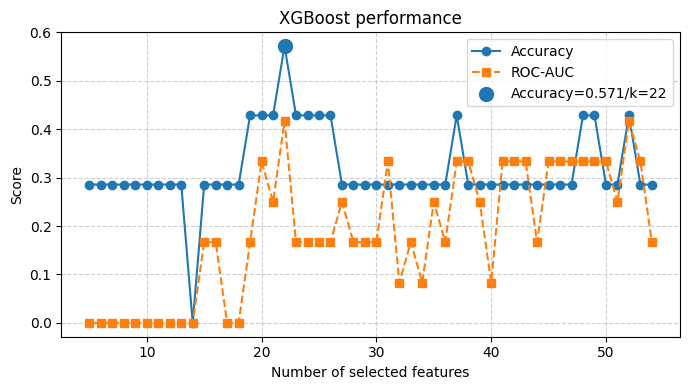


Accuracy = 0.571/ROC-AUC = 0.417/k = 22


In [15]:
ranking = kbest_features

param_dist = {
    "n_estimators": np.arange(20, 90, 10),
    "max_depth": [3, 4, 5, 6, 7],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
}

results = []
for k in range(5, 55, 1):
    print(f"\n=== Testing top {k} features ===")

    # Select k values
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    )

    search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_dist,
        n_iter=200,
        scoring="accuracy",
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Analyze
results = np.array(results)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

# Choose best by accuracy
best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, 'o-', label='Accuracy')
plt.plot(feature_counts, auc_scores, 's--', label='ROC-AUC')
plt.scatter(best_k, best_acc, s=100, zorder=5, label=f'Accuracy={best_acc:.3f}/k={best_k}')
plt.title('XGBoost performance')
plt.xlabel('Number of selected features')
plt.ylabel('Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nAccuracy = {best_acc:.3f}/ROC-AUC = {best_auc:.3f}/k = {best_k}")

## Model KBEST Features Tuning (Randomized Search CV) - Fingerprint

In [16]:
# Select the best_k features
top_feats_best = ranking.head(best_k).index.tolist()
print(f"\nUsing best_k = {best_k} features: {len(top_feats_best)} selected.")

X_train_sel = X_train[top_feats_best].copy()
X_test_sel = X_test[top_feats_best].copy()

# Concatenate best_k descriptors + fingerprints
X_train_final = pd.concat([X_train_sel, fp_train], axis=1)
X_test_final = pd.concat([X_test_sel, fp_test], axis=1)

print(f"Final train shape with fingerprints: {X_train_final.shape}")
print(f"Final test shape with fingerprints:  {X_test_final.shape}")

# RandomizedSearchCV
xgb_clf_final = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    random_state=42,
    n_jobs=-1
)

search_final = RandomizedSearchCV(
    estimator=xgb_clf_final,
    param_distributions=param_dist,
    n_iter=200,
    scoring="accuracy",
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

search_final.fit(X_train_final, y_train)

best_model_final = search_final.best_estimator_
y_pred_final = best_model_final.predict(X_test_final)
y_prob_final = best_model_final.predict_proba(X_test_final)[:, 1]

acc_final = accuracy_score(y_test, y_pred_final)
auc_final = roc_auc_score(y_test, y_prob_final)

print("\n=== FINAL MODEL (best_k + 256-bit RDKit fingerprint) ===")
print(f"Best parameters: {search_final.best_params_}")
print(f"Test Accuracy: {acc_final:.3f}")
print(f"Test ROC-AUC: {auc_final:.3f}")


Using best_k = 22 features: 22 selected.
Final train shape with fingerprints: (28, 278)
Final test shape with fingerprints:  (7, 278)

=== FINAL MODEL (best_k + 256-bit RDKit fingerprint) ===
Best parameters: {'subsample': 0.9, 'n_estimators': 60, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.9}
Test Accuracy: 0.429
Test ROC-AUC: 0.167


## Model LASSO Features Tuning (Randomized Search CV)


=== Testing top 5 features ===
Best parameters: {'subsample': 0.7, 'n_estimators': 30, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 1.0}
Accuracy: 0.143 | ROC-AUC: 0.167

=== Testing top 6 features ===
Best parameters: {'subsample': 0.9, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.3, 'colsample_bytree': 0.6}
Accuracy: 0.286 | ROC-AUC: 0.250

=== Testing top 7 features ===
Best parameters: {'subsample': 0.9, 'n_estimators': 80, 'max_depth': 3, 'learning_rate': 0.3, 'colsample_bytree': 0.9}
Accuracy: 0.286 | ROC-AUC: 0.167

=== Testing top 8 features ===
Best parameters: {'subsample': 0.7, 'n_estimators': 50, 'max_depth': 4, 'learning_rate': 0.3, 'colsample_bytree': 0.7}
Accuracy: 0.286 | ROC-AUC: 0.167

=== Testing top 9 features ===
Best parameters: {'subsample': 0.7, 'n_estimators': 70, 'max_depth': 6, 'learning_rate': 0.3, 'colsample_bytree': 0.9}
Accuracy: 0.429 | ROC-AUC: 0.167

=== Testing top 10 features ===
Best parameters: {'subsample': 1.0, 'n_estimato

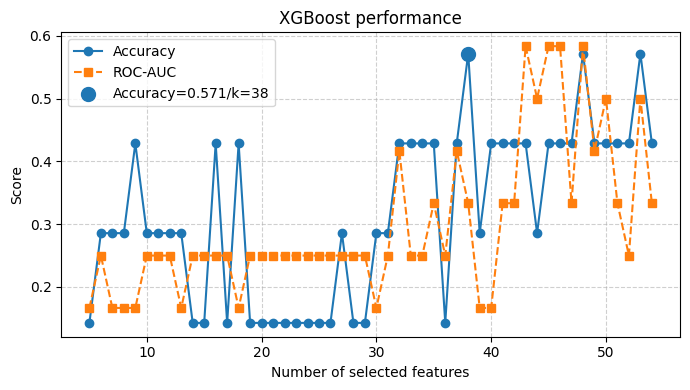


Accuracy = 0.571/ROC-AUC = 0.333/k = 38


In [17]:
ranking = lasso_features

param_dist = {
    "n_estimators": np.arange(20, 90, 10),
    "max_depth": [3, 4, 5, 6, 7],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
}

results = []
for k in range(5, 55, 1):
    print(f"\n=== Testing top {k} features ===")

    # Select k values
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    )

    search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_dist,
        n_iter=200,
        scoring="accuracy",
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Analyze
results = np.array(results)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

# Choose best by accuracy
best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, 'o-', label='Accuracy')
plt.plot(feature_counts, auc_scores, 's--', label='ROC-AUC')
plt.scatter(best_k, best_acc, s=100, zorder=5, label=f'Accuracy={best_acc:.3f}/k={best_k}')
plt.title('XGBoost performance')
plt.xlabel('Number of selected features')
plt.ylabel('Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nAccuracy = {best_acc:.3f}/ROC-AUC = {best_auc:.3f}/k = {best_k}")

## Model LASSO Features Tuning (Randomized Search CV) - Fingerprint

In [18]:
# Select the best_k features
top_feats_best = ranking.head(best_k).index.tolist()
print(f"\nUsing best_k = {best_k} features: {len(top_feats_best)} selected.")

X_train_sel = X_train[top_feats_best].copy()
X_test_sel = X_test[top_feats_best].copy()

# Concatenate best_k descriptors + fingerprints
X_train_final = pd.concat([X_train_sel, fp_train], axis=1)
X_test_final = pd.concat([X_test_sel, fp_test], axis=1)

print(f"Final train shape with fingerprints: {X_train_final.shape}")
print(f"Final test shape with fingerprints:  {X_test_final.shape}")

# RandomizedSearchCV
xgb_clf_final = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    random_state=42,
    n_jobs=-1
)

search_final = RandomizedSearchCV(
    estimator=xgb_clf_final,
    param_distributions=param_dist,
    n_iter=200,
    scoring="accuracy",
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

search_final.fit(X_train_final, y_train)

best_model_final = search_final.best_estimator_
y_pred_final = best_model_final.predict(X_test_final)
y_prob_final = best_model_final.predict_proba(X_test_final)[:, 1]

acc_final = accuracy_score(y_test, y_pred_final)
auc_final = roc_auc_score(y_test, y_prob_final)

print("\n=== FINAL MODEL (best_k + 256-bit RDKit fingerprint) ===")
print(f"Best parameters: {search_final.best_params_}")
print(f"Test Accuracy: {acc_final:.3f}")
print(f"Test ROC-AUC: {auc_final:.3f}")


Using best_k = 38 features: 38 selected.
Final train shape with fingerprints: (28, 294)
Final test shape with fingerprints:  (7, 294)

=== FINAL MODEL (best_k + 256-bit RDKit fingerprint) ===
Best parameters: {'subsample': 0.7, 'n_estimators': 40, 'max_depth': 7, 'learning_rate': 0.2, 'colsample_bytree': 0.7}
Test Accuracy: 0.429
Test ROC-AUC: 0.167
